In [571]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from ignite.metrics.accuracy import _BaseClassification
from ignite.exceptions import NotComputableError
from ignite.utils import to_onehot
from ignite.metrics.metric import reinit__is_reduced
from typing import Sequence, Callable, Optional, Union

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
__all__ = ["Precision"]

In [572]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [624]:
df = pd.read_csv("LSTM2_A1_50.csv")
df.shape

(99, 40)

In [625]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,23:08:33.431,A,23:08:38.087,B,23:08:41.801,C,23:08:42.512,D,23:08:47.256,E,...,23:09:22.922,A,23:09:27.76,B,23:09:30.384,C,23:09:35.054,D,23:09:35.082,E
1,6:06:49.116,A,6:06:52.285,B,6:06:54.988,C,6:06:55.803,D,6:06:58.917,E,...,6:07:25.856,A,6:07:29.262,B,6:07:32.048,C,6:07:36.802,D,6:07:38.743,E
2,18:22:5.053,A,18:22:5.154,B,18:22:5.606,C,18:22:8.6,D,18:22:11.282,E,...,18:22:35.54,A,18:22:36.197,B,18:22:40.615,C,18:22:44.81,D,18:22:46.388,E
3,19:44:7.809,A,19:44:9.132,B,19:44:10.099,C,19:44:10.89,D,19:44:15.248,E,...,19:44:38.551,A,19:44:40.569,B,19:44:40.982,C,19:44:44.951,D,19:44:46.642,E
4,11:31:12.886,A,11:31:16.877,B,11:31:20.331,C,11:31:23.259,D,11:31:26.645,E,...,11:32:4.716999999999999,A,11:32:7.103,B,11:32:8.424,C,11:32:9.38,D,11:32:10.229,E


In [626]:
dic = {'A':'1','B':'2','C':'3','D':'4','E':'5','F':'6','G':'7','H':'8','I':'9','J':'0'}
t1 = ()

for colunm in range(len(df)):
    formerTime = pd.Timestamp(df.iloc[colunm,0])
    for row in range(0,40,2):
        latterTime = pd.Timestamp(df.iloc[colunm,row])
        timeStamp = latterTime - formerTime
        timeStampToSec = timeStamp.total_seconds()
        df.iloc[colunm,row] = timeStampToSec
        formerTime = latterTime
        for key in dic.keys():
            if df.iloc[colunm,row + 1] == key:
                df.iloc[colunm,row + 1] = int(dic.get(key))

In [627]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,0,1,4.656,2,3.714,3,0.711,4,4.744,5,...,3.743,1,4.838,2,2.624,3,4.67,4,0.028,5
1,0,1,3.169,2,2.703,3,0.815,4,3.114,5,...,2.268,1,3.406,2,2.786,3,4.754,4,1.941,5
2,0,1,0.101,2,0.452,3,2.994,4,2.682,5,...,0.983,1,0.657,2,4.418,3,4.195,4,1.578,5
3,0,1,1.323,2,0.967,3,0.791,4,4.358,5,...,2.465,1,2.018,2,0.413,3,3.969,4,1.691,5
4,0,1,3.991,2,3.454,3,2.928,4,3.386,5,...,4.722,1,2.386,2,1.321,3,0.956,4,0.849,5


In [628]:
df.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
94,0,1,1936.81,5,1392.67,4,-85636.8,2,1878.02,3,...,3508.07,3,227.146,2,735.29,1,2772.1,3,3597.99,5
95,0,1,3427.1,1,2491.22,2,1305.49,4,256.944,3,...,562.556,5,3089.72,3,606.333,2,647.21,1,2319.59,2
96,0,1,349.59,1,1054.92,4,2398.08,2,2480.71,4,...,1294.74,1,935.64,1,3437.48,3,531.103,3,2838.25,2
97,0,1,2204.66,3,1707.76,2,2806.08,1,2184.7,4,...,218.617,5,859.834,4,1882.05,3,3127.75,5,1154.09,1
98,0,1,186.755,1,1765.9,4,1254.39,4,2155.45,2,...,1327.03,2,3206.3,3,2473.19,4,734.303,5,1643.77,4


In [629]:
train_df, val_df = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [630]:
print(len(train_df));
print(len(val_df));
print(len(test_df));

84
10
5


In [631]:
def create_dataset(df):
    
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [632]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)

In [633]:
'''
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)
'''

'\ntest_normal_dataset, _, _ = create_dataset(test_df)\ntest_anomaly_dataset, _, _ = create_dataset(anomaly_df)\n'

In [634]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [635]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [636]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [637]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [638]:
class F1_Loss(nn.Module):

    def __init__(self, epsilon=1e-1):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true):
      
        y_true = y_true.flatten().to(torch.long)
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        
        y_true = F.one_hot(y_true, 10).to(torch.float64)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(0).to(torch.float64)
        tn = ((1 - y_true) * (1 - y_pred)).sum(0).to(torch.float64)
        fp = ((1 - y_true) * y_pred).sum(0).to(torch.float64)
        fn = (y_true * (1 - y_pred)).sum(0).to(torch.float64)
        
        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)
        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
     
        '''
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        precision = precision.clamp(min=self.epsilon, max=1-self.epsilon)
        recall = recall.clamp(min=self.epsilon, max=1-self.epsilon)
        
        for i in range(len(y_pred_pc)):
            y_pred_pc[i] = round(y_pred_pc[i])
            
        precision_pc = precision_score(y_true_pc, y_pred_pc, average='macro')
        recall_pc = recall_score(y_true_pc, y_pred_pc, average='macro')
        '''
        return 1 - f1.mean(), 1 - precision.mean(), 1 - recall.mean()
    
f1_loss = F1_Loss().cuda()

In [639]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
  criterion = nn.MSELoss(reduction='mean').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())
        print(f1_loss(seq_pred, seq_true))

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
        
    print(f'Epoch {epoch}: trainLoss {train_loss} / valLoss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [640]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=1
)

(tensor(0.8465, dtype=torch.float64), tensor(0.9002, dtype=torch.float64), tensor(0.4120, dtype=torch.float64))


RuntimeError: Class values must be smaller than num_classes.

In [265]:
class F1_Loss(nn.Module):

    def __init__(self, epsilon=1e-1):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true):
      
        print(y_pred);
        y_true = y_true.flatten().to(torch.long)
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        
        y_true = F.one_hot(y_true, 10).to(torch.float64)
        y_pred = F.softmax(y_pred, dim=1)
        tp = (y_true * y_pred).sum(dim=0).to(torch.float64)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float64)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float64)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float64)
        
        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)
        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        
        print(precision);
        print(recall);
     
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        '''
        precision = precision.clamp(min=self.epsilon, max=1-self.epsilon)
        recall = recall.clamp(min=self.epsilon, max=1-self.epsilon)
        '''
        
        '''
        for i in range(len(y_pred_pc)):
            y_pred_pc[i] = round(y_pred_pc[i])
            
        precision_pc = precision_score(y_true_pc, y_pred_pc, average='macro')
        recall_pc = recall_score(y_true_pc, y_pred_pc, average='macro')
        '''
        return 1 - f1.mean(), 1- precision.mean(), 1- recall.mean()
    
f1_loss = F1_Loss().cuda()

In [266]:
print(f1_loss(seq_pred, seq_true))

tensor([[6.4175],
        [7.7488],
        [7.9528],
        [7.9810],
        [7.9848],
        [7.9853],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854],
        [7.9854]], grad_fn=<AddmmBackward>)
tensor([0.1746, 0.0998, 0.1995, 0.1247, 0.1496, 0.0499, 0.0499, 0.0499, 0.0499,
        0.0499], dtype=torch.float64, grad_fn=<DivBackward0>)
tensor([0.9859, 0.9756, 0.9877, 0.9804, 0.9836, 0.9524, 0.9524, 0.9524, 0.9524,
        0.9524], dtype=torch.flo

In [263]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.MSELoss(reduction='mean').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device).float()
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)
    
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
        
  return predictions, losses

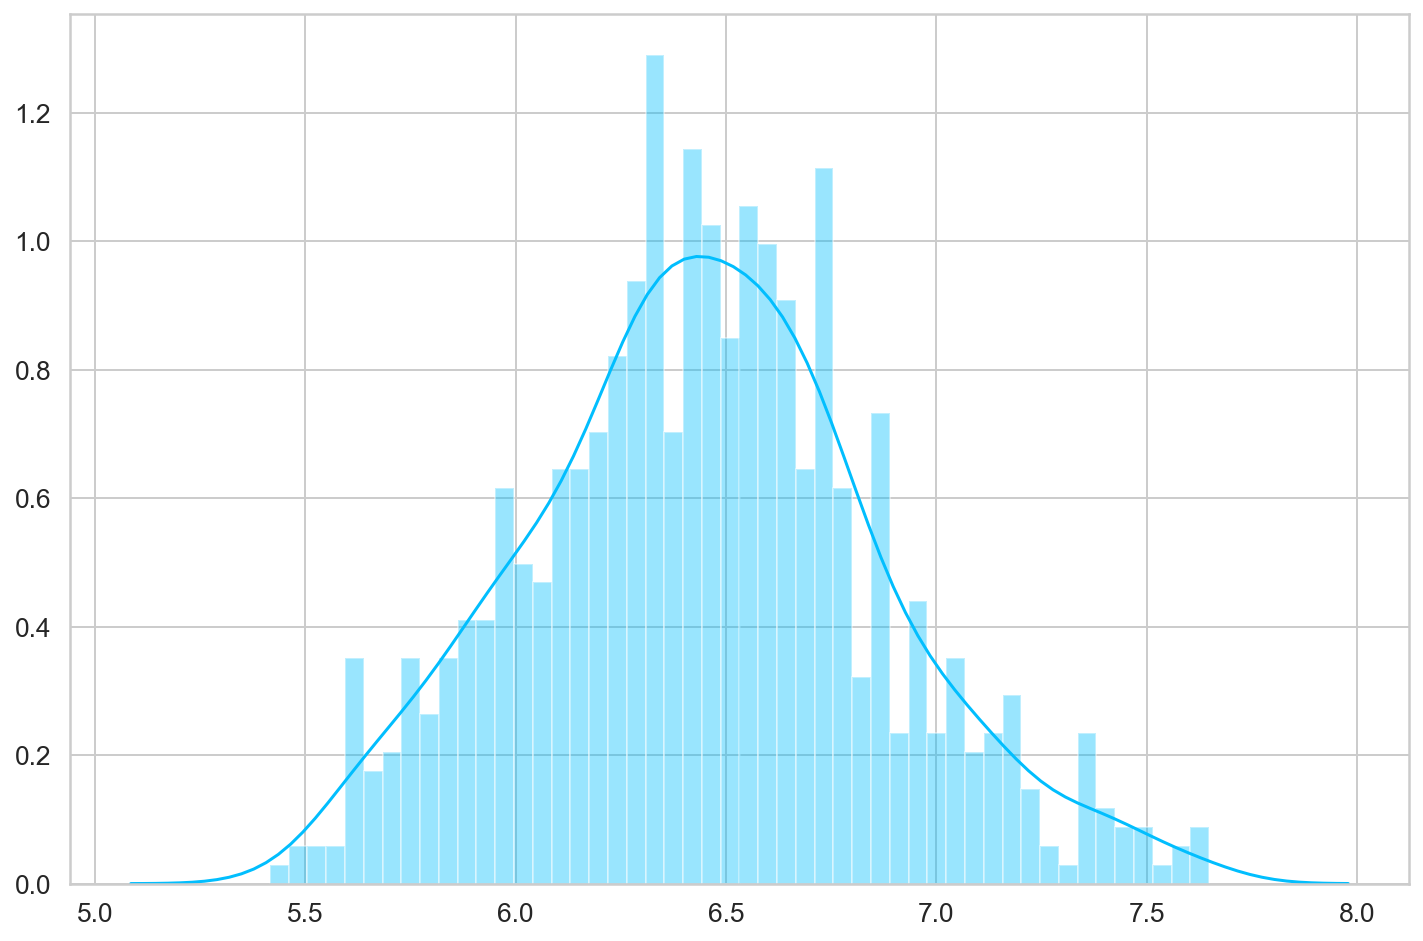

In [1087]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [1145]:
sum = 0
for i in range(len(losses)):
    if losses[i] < 7.2:
        sum = sum + 1
        
print(sum)
print(len(losses))
print(sum/len(losses)*100)


▶

732
764
95.81151832460732


In [1146]:
THRESHOLD = 7

In [1134]:
len(test_normal_dataset)

45

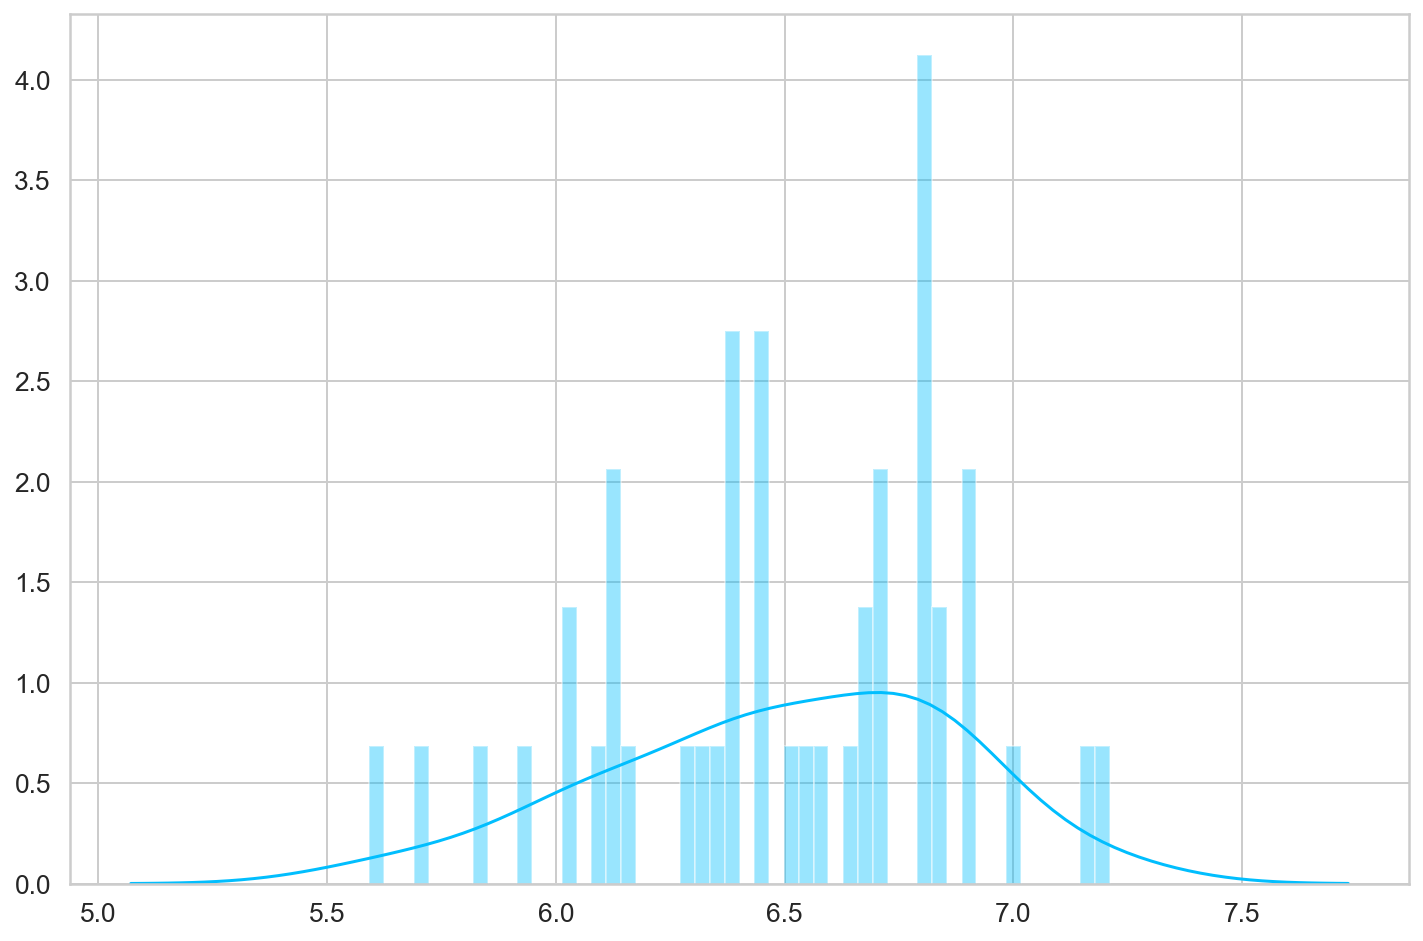

In [1135]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [1136]:
correct = 0
for i in range(len(pred_losses)):
    if(pred_losses[i] <= THRESHOLD):
        correct = correct + 1
        
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 43/45


In [1137]:
anomaly_dataset = test_anomaly_dataset

[615535488.0, 700500160.0, 562793856.0, 498547296.0, 570992896.0, 605581824.0, 526324064.0, 538744576.0, 588948608.0, 506215424.0, 453989376.0, 689738112.0, 907679424.0, 362611072.0, 454194848.0, 659762944.0, 838544896.0, 495883328.0, 507547072.0, 516031424.0, 888204672.0, 682659712.0, 440436800.0, 564790912.0, 624515456.0, 728688256.0, 904527360.0, 296346176.0, 672754816.0, 594834432.0, 542613376.0, 551188736.0, 860061568.0, 719418432.0, 462920512.0, 483113632.0, 287857856.0, 463756224.0, 444958560.0, 606034112.0, 633437568.0, 634188160.0, 738802816.0, 653817216.0, 896761344.0, 687219136.0, 820710272.0, 802623104.0, 907747840.0, 527580352.0, 569457600.0, 580035712.0, 711690176.0, 291272032.0, 590579264.0, 651291008.0, 428093760.0, 597632128.0, 679804288.0, 493510336.0, 781536512.0, 974645760.0, 1085021568.0, 435815776.0, 444512096.0, 707411840.0, 661423488.0, 578510464.0, 657079872.0, 558724352.0, 328791968.0, 521211456.0, 666828672.0, 434731456.0, 780256064.0, 473727936.0, 901740544.

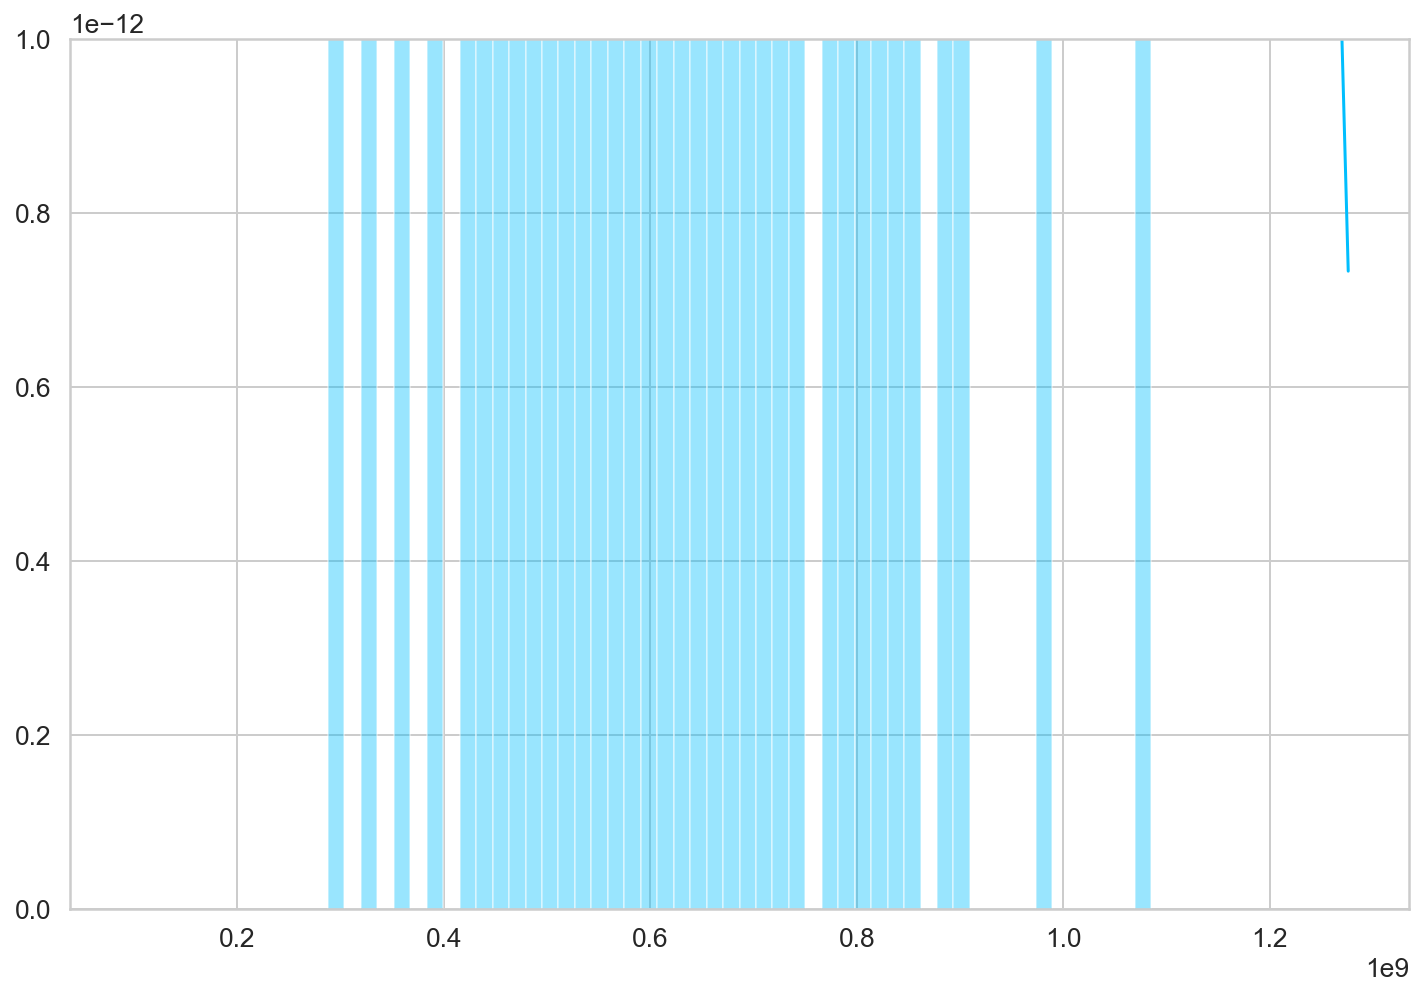

In [1138]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);
print(pred_losses)

In [1139]:
correct = 0
for i in range(len(pred_losses)):
    if(pred_losses[i] > THRESHOLD):
        correct = correct + 1
        
print(f'Correct normal predictions: {correct}/{len(pred_losses)}')

Correct normal predictions: 99/99
